## Post-processing
#### Here we fit a multioutput random forest model on the area of each of the segmentation classes to identify those classes which should not have existed in the image.
#### We then display segmentation results on test set along with confusion matrix of the classification results


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchvision.models as models

from PIL import Image
import json
import os
import random
from scipy.sparse import csr_matrix
import time
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from segmentation_unet import *
from train import *
from postprocessing_func import *
from image_dataset import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from joblib import dump, load

In [2]:

batch_size = 16
num_workers = 2
sample_per_class = 200
n_epochs = 8
accumulate_steps = 4

base_dir = '/kaggle/input'
train_image_dir = os.path.join(base_dir,'train')
dev_image_dir = os.path.join(base_dir,'dev')
test_image_dir = os.path.join(base_dir,'test')

ds,train_dl = dataloader(train_image_dir,'train.csv',batch_size,sample_per_class = 2000)
dev_ds,dev_dl = dataloader(dev_image_dir,'dev.csv',batch_size)
_,test_dl = dataloader(test_image_dir,'test.csv',batch_size)

train = pd.read_csv(os.path.join(dev_image_dir,'dev.csv'))

op_layers = len(train.ClassId.drop_duplicates())
net = UNet(op_layers)
device = torch.device("cuda")
net.to(device)

checkpoint = torch.load(os.path.join(base_dir,'unet-final','model_final.h5py'))
net.load_state_dict(checkpoint['model_state_dict'],strict=False)


11066


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:638: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


<All keys matched successfully>

### Train random forest on dev set

In [3]:
num_classes = 7
threshold = 0.5

y_op_list = torch.zeros((1,num_classes)).to(device)
y_class_list = torch.zeros((1,num_classes)).to(device)

for x,y in dev_dl:
    x,y = x.to(device),y.to(device)
    _,y_op = net_op(net,x,threshold)
    y_class =  y_one_hot(y,num_classes)
    y_op_list = torch.cat([y_op_list,y_op],dim = 0)
    y_class_list = torch.cat([y_class_list,y_class],dim = 0)

y_class_list = y_class_list[1:,1:].to('cpu').numpy()
y_op_list = y_op_list[1:,1:].to('cpu').numpy()

forest = RandomForestClassifier(random_state=1)
model_dev = MultiOutputClassifier(forest, n_jobs=-1)
model_dev.fit(y_op_list,y_class_list)
dump(model,os.path.join(os.getcwd(),'models','post_unet_model_dev.joblib') )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


### Train random forest on train set

In [5]:
num_classes = 7
threshold = 0.5

y_op_list = torch.zeros((1,num_classes)).to(device)
y_class_list = torch.zeros((1,num_classes)).to(device)

for x,y in train_dl:
    x,y = x.to(device),y.to(device)
    _,y_op = net_op(net,x,threshold)
    y_class =  y_one_hot(y,num_classes)
    y_op_list = torch.cat([y_op_list,y_op],dim = 0)
    y_class_list = torch.cat([y_class_list,y_class],dim = 0)

y_class_list = y_class_list[1:,1:].to('cpu').numpy()
y_op_list = y_op_list[1:,1:].to('cpu').numpy()

forest = RandomForestClassifier(random_state=1)
model_train = MultiOutputClassifier(forest, n_jobs=-1)
model_train.fit(y_op_list,y_class_list)
dump(model,os.path.join(os.getcwd(),'models','post_unet_model_train.joblib'))

['post_unet_model.joblib']

### Test both the models on test set (average number of correctly classified classes in the entire image is the performance metric)

In [6]:
y_op_list = torch.zeros((1,num_classes)).to(device)
y_class_list = torch.zeros((1,num_classes)).to(device)

for x,y in test_dl:
    x,y = x.to(device),y.to(device)
    _,y_op = net_op(net,x,threshold)
    y_class =  y_one_hot(y,num_classes)
    y_op_list = torch.cat([y_op_list,y_op],dim = 0)
    y_class_list = torch.cat([y_class_list,y_class],dim = 0)

y_class_list = y_class_list[1:,1:].to('cpu').numpy()
y_op_list = y_op_list[1:,1:].to('cpu').numpy()

y_predict = model_dev.predict(y_op_list)
print("Classification Accuracy (for model_dev) : ",((y_op_list> 0).astype(int) == y_class_list).astype('int').sum(axis = 1).mean())
print("Classification Accuracy with Post Processing (for model_dev) : ",(y_predict == y_class_list).astype('int').sum(axis = 1).mean())

y_predict = model_train.predict(y_op_list)
print("Classification Accuracy (for model_train) : ",((y_op_list> 0).astype(int) == y_class_list).astype('int').sum(axis = 1).mean())
print("Classification Accuracy with Post Processing (for model_train) : ",(y_predict == y_class_list).astype('int').sum(axis = 1).mean())

np.savetxt("y_predict_op.csv", y_predict, delimiter=",")
np.savetxt("y_class_list_op.csv", y_class_list, delimiter=",")
np.savetxt("y_op_list_op.csv",y_op_list,delimiter = ",")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


Classification Accuracy :  4.92
Classification Accuracy with Post Processing :  5.12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


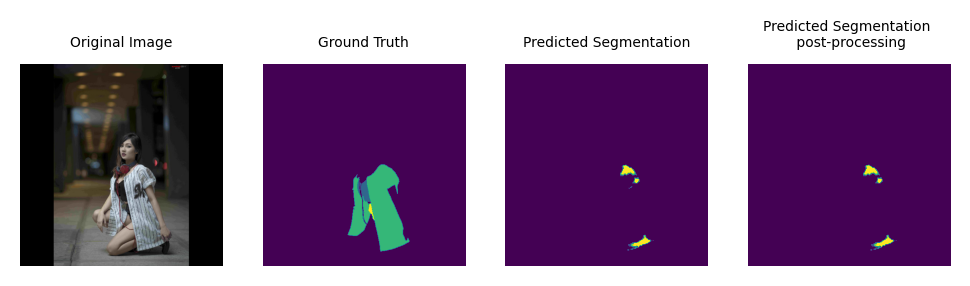

Actual Classes : [0, 2, 4, 6]
Predicted Classes: [0, 2, 4]
Predicted Classes post-processing : [0, 4]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


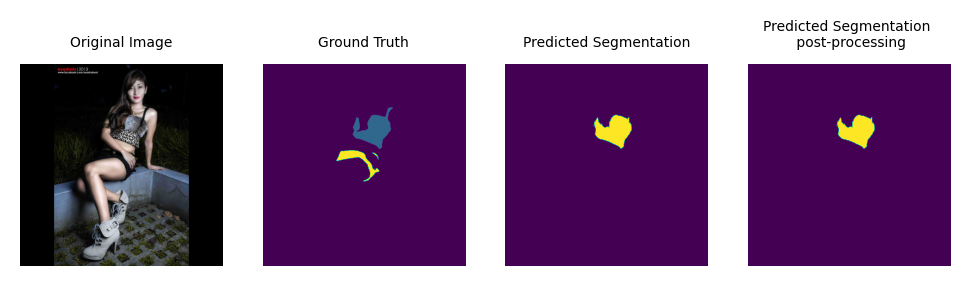

Actual Classes : [0, 2, 6]
Predicted Classes: [0, 2]
Predicted Classes post-processing : [0, 2]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


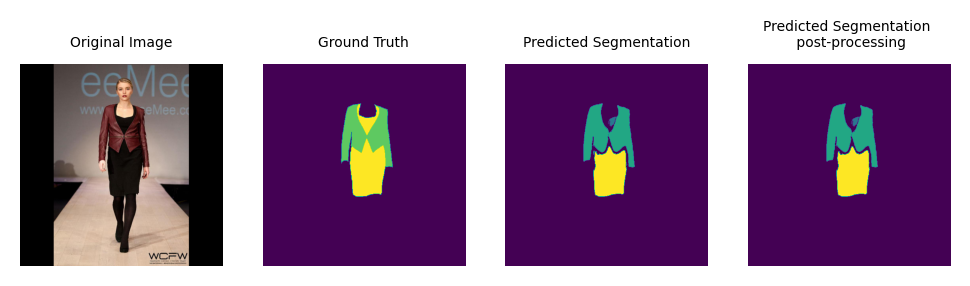

Actual Classes : [0, 3, 4]
Predicted Classes: [0, 2, 3, 4, 5]
Predicted Classes post-processing : [0, 2, 3, 5]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


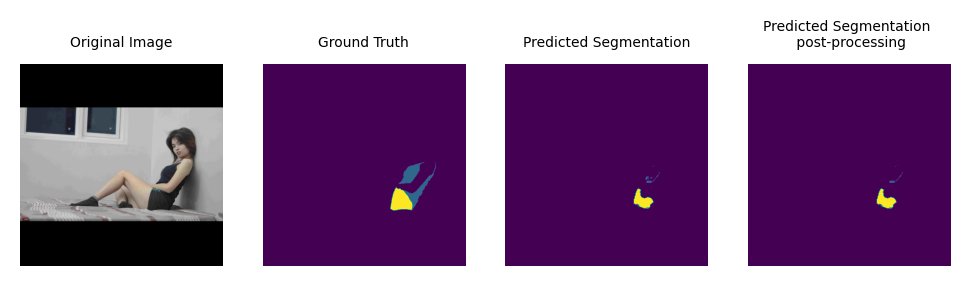

Actual Classes : [0, 2, 6]
Predicted Classes: [0, 2, 4, 6]
Predicted Classes post-processing : [0, 2, 6]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


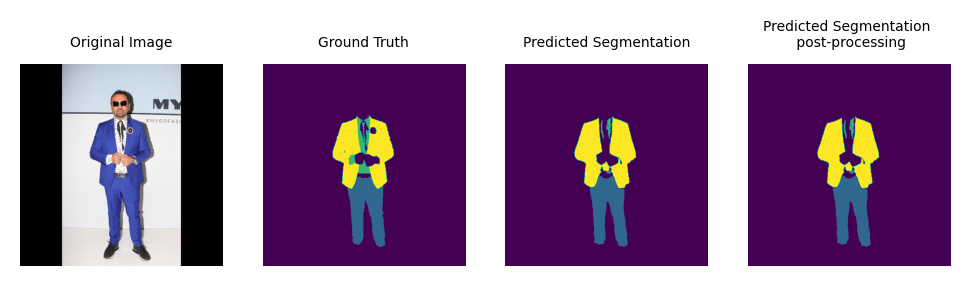

Actual Classes : [0, 1, 2, 3]
Predicted Classes: [0, 1, 2, 3]
Predicted Classes post-processing : [0, 1, 2, 3]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


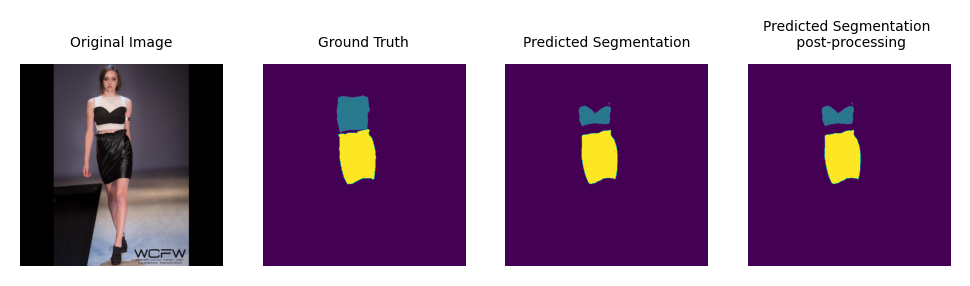

Actual Classes : [0, 2, 5]
Predicted Classes: [0, 2, 5]
Predicted Classes post-processing : [0, 2, 5]


In [7]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
fontsize = 5

params = {'axes.titlesize':fontsize}

pylab.rcParams.update(params)

threshold = 0.5
i=0

for x,y in dev_ds:
    
    plt.figure(dpi = 200)
    
    y_op,y_op_class = net_op(net,x.to(device),threshold)
    y_postop = model.predict(y_op_class[:,1:].to('cpu').numpy())
    y_postop_disp = clean_op(y_postop,y_op)
    
    plt.subplot(1,4,1)
    plt.imshow(x[0,:,:,:].permute([1,2,0]).type(torch.int))
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1,4,2)
    plt.imshow(y[0,:,:])
    plt.title("Ground Truth")
    plt.axis("off")
    
    y_op_disp =  torch.argmax(y_op.to('cpu'),axis = 1)
    plt.subplot(1,4,3)
    plt.imshow(y_op_disp[0,:,:].type(torch.float))
    plt.title("Predicted Segmentation")
    plt.axis("off")
    
    plt.subplot(1,4,4)
    plt.imshow(y_postop_disp[0,:,:].type(torch.float))
    plt.title("Predicted Segmentation \n post-processing")
    plt.axis("off")
    
    plt.show()
    
    print('Actual Classes : ' + str(list(y[0:1,:,:].unique().numpy())))
    print('Predicted Classes: ' + str(list(y_op_disp[0:1,:,:].unique().numpy())))
    print('Predicted Classes post-processing : '+ str(list(y_postop_disp[0:1,:,:].unique().numpy())))
    
    i += 1
    if i==10:
        break

